In [2]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # Use 300 for PDF, 100 for slides
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

# Building Machine Learning Systems (with Python)
Joaquin Vanschoren, Eindhoven University of Technology

## Overview
* Getting started: Python ecosystem
* Data preprocessing
* Machine Learning systems
    * Classification: 
    * Regression
    * Evaluation
* Deep Learning
* Next:
    * Data and experiment management with OpenML
    * Hands-on exercises

# Why Python?
* Many data-heavy applications are now developed in Python
* Highly readable, less complexity, fast prototyping
* Easy to offload number crunching to underlying C/Fortran/... 
* Easy to install and import many rich libraries
    - numpy: efficient data structures
    - scipy: fast numerical recipes
    - matplotlib: high-quality graphs
    - scikit-learn: machine learning algorithms
    - tensorflow: neural networks
    - ...

<img src="../images/tut_ecosystem.jpg" alt="ml" style="width: 1000px;"/>

# Numpy, Scipy, Matplotlib
* We'll illustrate these with a practical example
* Many good tutorials online
    - [Jake VanderPlas' book and notebooks](https://github.com/jakevdp/PythonDataScienceHandbook)
    - [J.R. Johansson's notebooks](https://github.com/jrjohansson/scientific-python-lectures)
    - [DataCamp](https://www.datacamp.com)
    - ...

In [3]:
from scipy.stats import gamma
np.random.seed(3)  # to reproduce the data

def gen_web_traffic_data():
    '''
    This function generates some fake data that first shows a weekly pattern 
    for a couple weeks before it grows exponentially.
    '''
    # 31 days, 24 hours
    x = np.arange(1, 31*24)
    
    # Sine wave with weekly rhythm + noise + exponential increase
    y = np.array(200*(np.sin(2*np.pi*x/(7*24))), dtype=np.float32)
    y += gamma.rvs(15, loc=0, scale=100, size=len(x))
    y += 2 * np.exp(x/100.0)
    y = np.ma.array(y, mask=[y<0])

    return x, y

def plot_web_traffic(x, y, models=None, mx=None, ymax=None):
    '''
    Plot the web traffic (y) over time (x). 
    
    If models is given, it is expected to be a list fitted models,
    which will be plotted as well (used later).
    '''
    plt.figure(figsize=(12,6), dpi=300) # width and height of the plot in inches
    plt.scatter(x, y, s=10)
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks([w*7*24 for w in range(20)], 
               ['week %i' %w for w in range(20)])
    
    if models: 
        colors = ['g', 'r', 'm', 'b', 'k']
        linestyles = ['-', '-.', '--', ':', '-']

        if mx is None:
            mx = np.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")
        
    plt.autoscale()
    if ymax:
        plt.ylim(ymax=ymax)

    plt.grid()
    plt.ylim(ymin=0)

## Example: Modelling web traffic
* We generate some artificial data to mimic web traffic data
    - E.g. website visits, tweets with certain hashtag,...
    - Weekly rhythm + noise + exponential increase

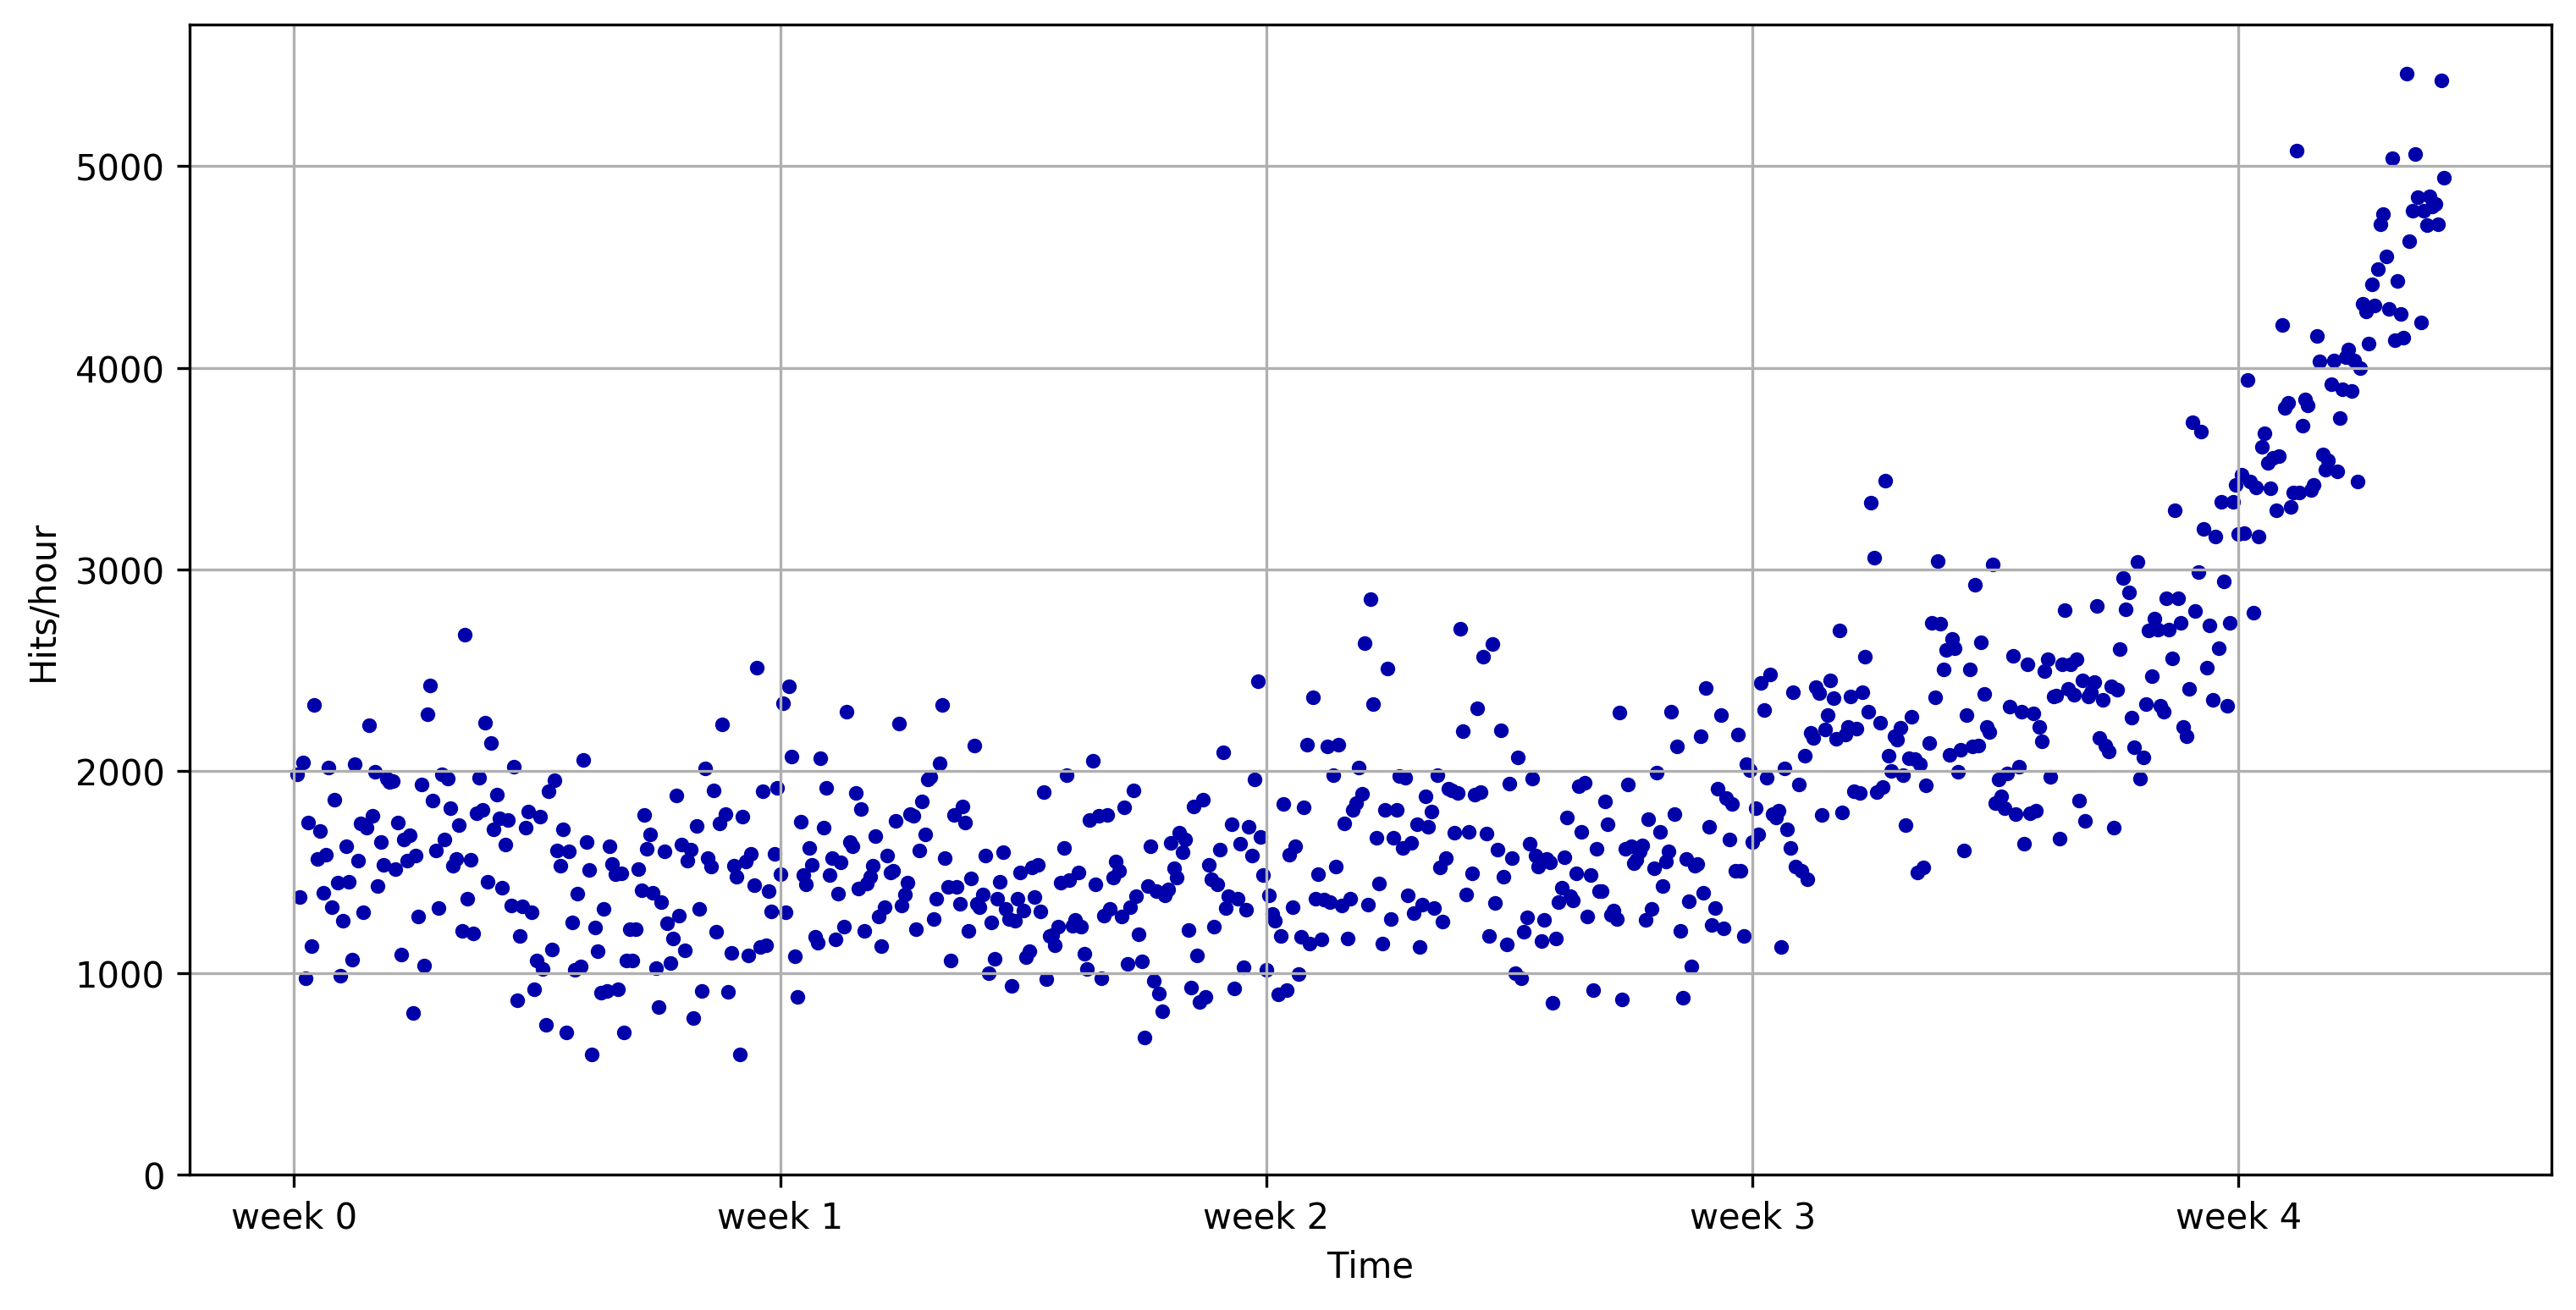

In [6]:
x, y = gen_web_traffic_data()
plot_web_traffic(x, y)

### Use numpy to fit some polynomial lines
* `polyfit` fits a polynomial of degree d
*  `poly1d` evaluates the function using the learned coefficients
* Plot with matplotlib

```python
f2 = np.poly1d(np.polyfit(x, y, 2))
f10 = np.poly1d(np.polyfit(x, y, 10))
f50 = np.poly1d(np.polyfit(x, y, 50))

mx = np.linspace(0, x[-1], 1000)
plt.plot(mx, f2(mx))
```

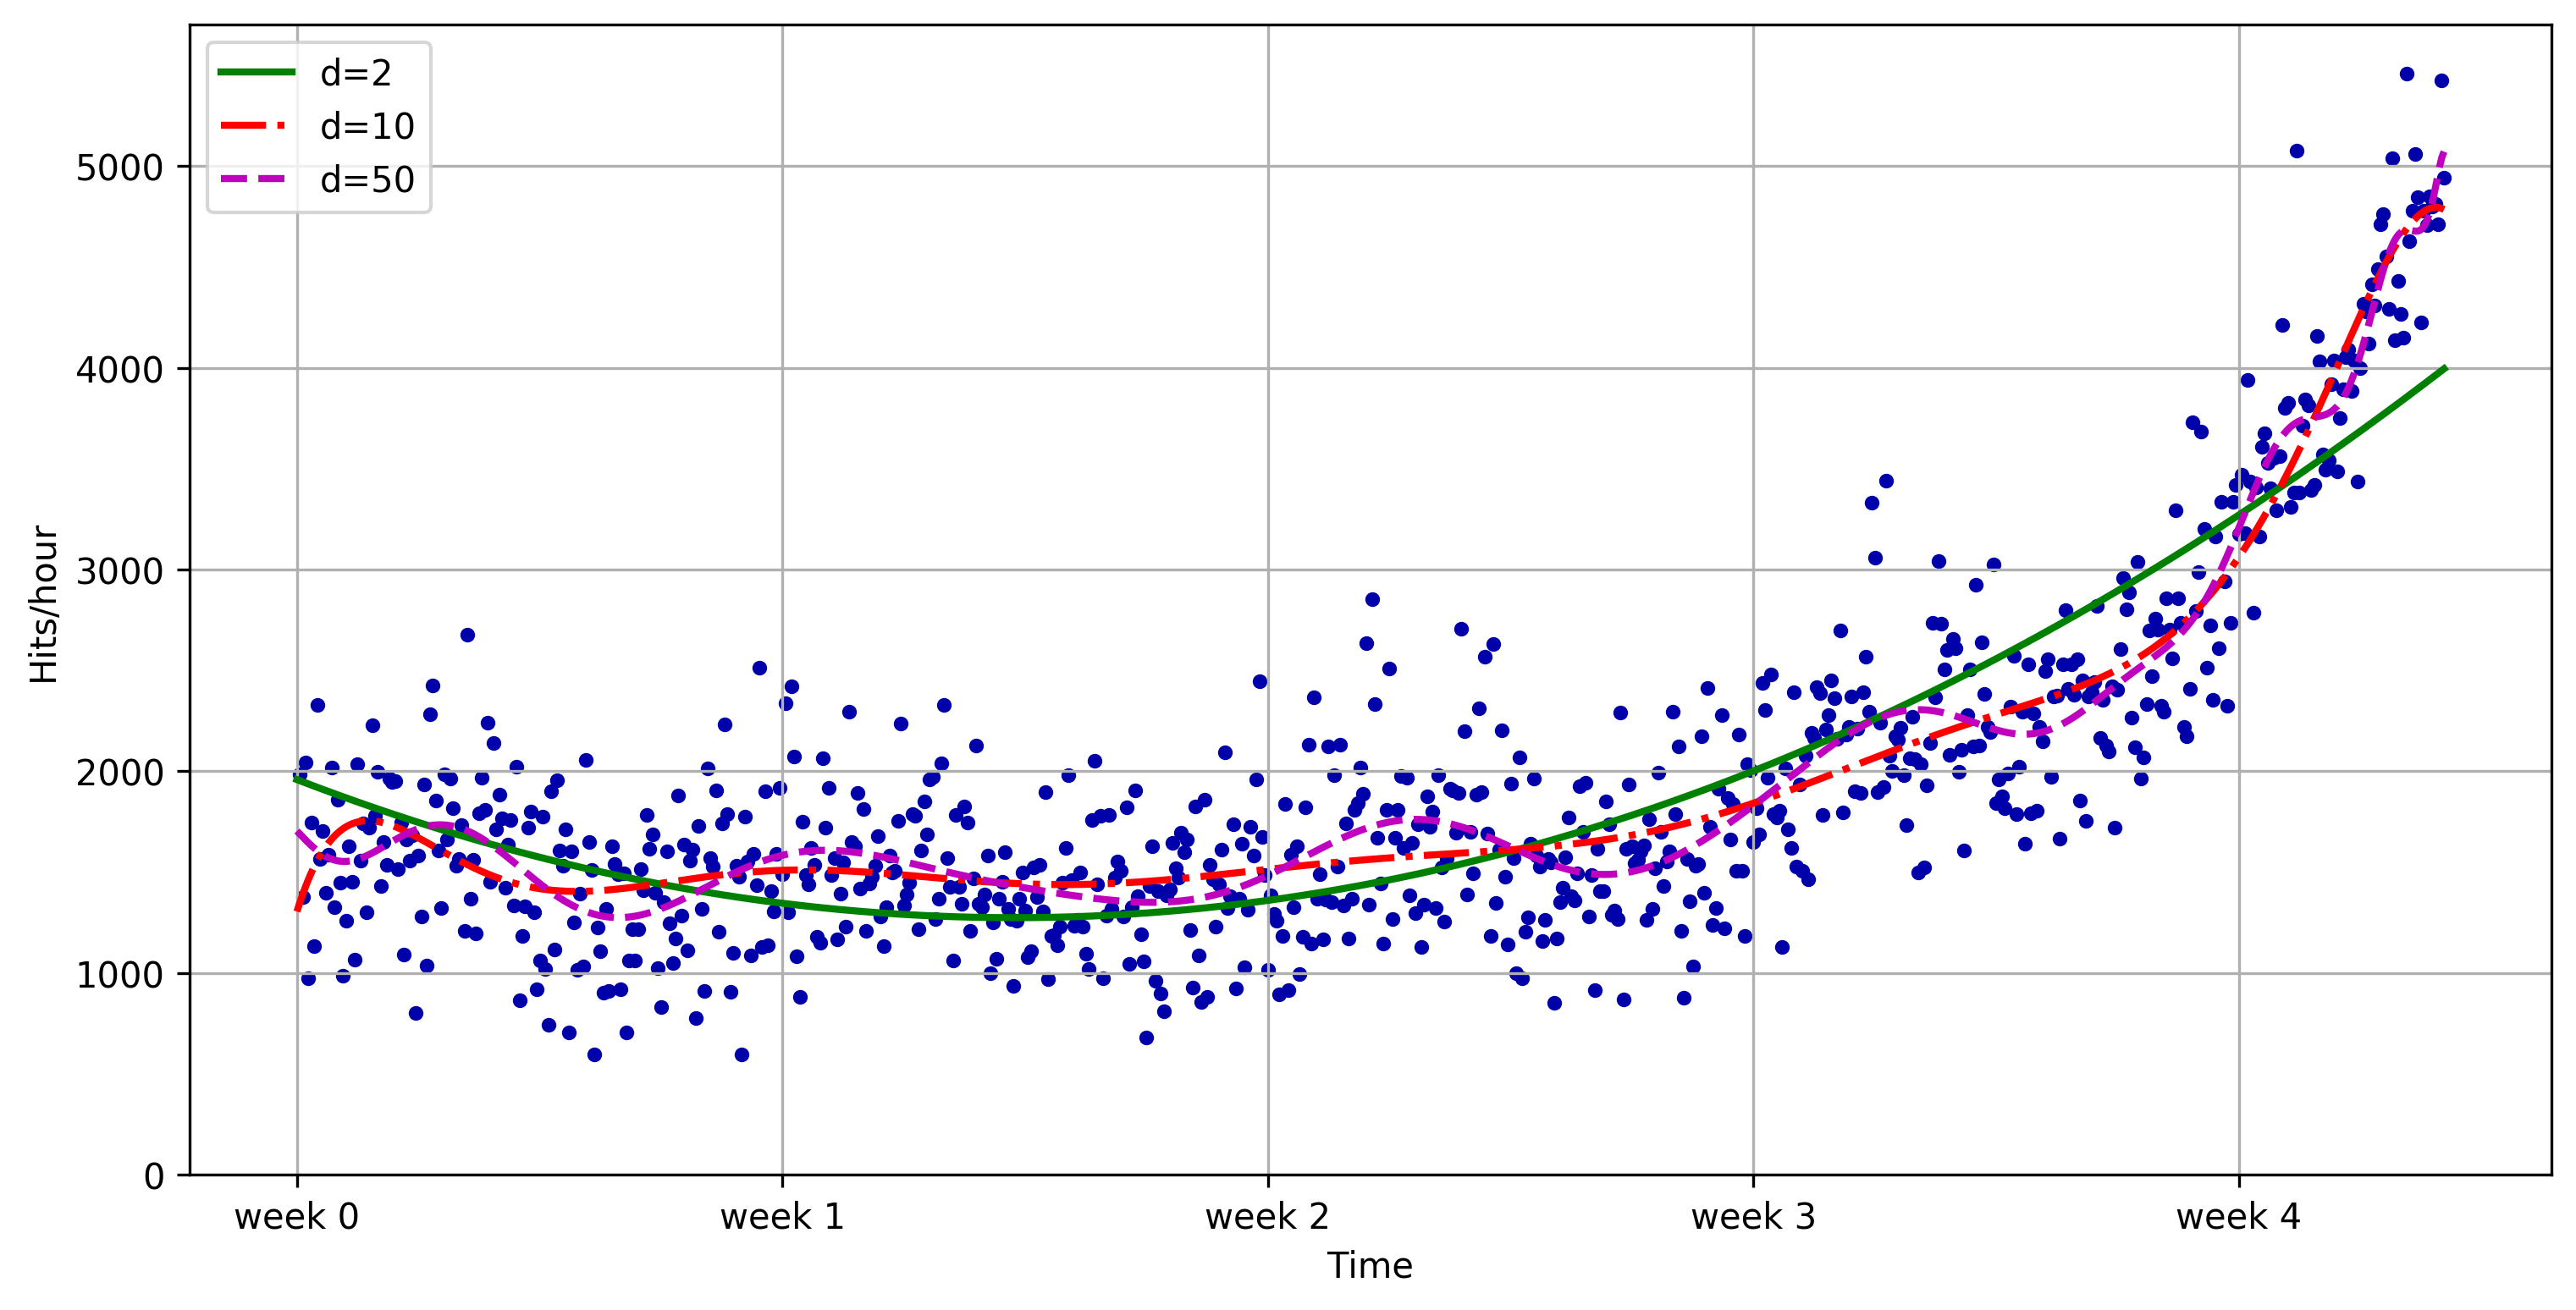

In [7]:
f2 = np.poly1d(np.polyfit(x, y, 2))
f10 = np.poly1d(np.polyfit(x, y, 10))
f50 = np.poly1d(np.polyfit(x, y, 50))
plot_web_traffic(x, y, [f2,f10,f50])

### Evaluate
* Using root mean squared error: $\sqrt{\sum_i (f(x_i) - y_i)^2}$
* The degree of the polynomial needs to be tuned to the data
* Predictions don't look great. We need more sophisticated methods.

In [10]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

mx=np.linspace(0, 6 * 7 * 24, 100)

def error(f, x, y):
    return np.sqrt(np.sum((f(x)-y)**2))

@interact
def play_with_degree(degree=(1,30,2)):
    f = np.poly1d(np.polyfit(x, y, degree))
    plot_web_traffic(x, y, [f], mx=mx, ymax=10000)
    print("Training error for d=%i: %f" % (f.order, error(f, x, y)))

interactive(children=(IntSlider(value=15, description='degree', max=30, min=1, step=2), Output()), _dom_classe…

# scikit-learn
One of the most prominent Python libraries for machine learning:

* Contains many state-of-the-art machine learning algorithms
* Builds on numpy (fast), implements advanced techniques
* Wide range of evaluation measures and techniques
* Offers [comprehensive documentation](http://scikit-learn.org/stable/documentation) about each algorithm
* Widely used, and a wealth of [tutorials](http://scikit-learn.org/stable/user_guide.html) and code snippets are available 
* Works well with numpy, scipy, pandas, matplotlib,...

## Algorithms
See the [Reference](http://scikit-learn.org/dev/modules/classes.html)

__Supervised learning:__

* Linear models (Ridge, Lasso, Elastic Net, ...)
* Support Vector Machines
* Tree-based methods (Classification/Regression Trees, Random Forests,...)
* Nearest neighbors
* Neural networks 
* Gaussian Processes
* Feature selection

__Unsupervised learning:__
    
* Clustering (KMeans, ...)
* Matrix Decomposition (PCA, ...)
* Manifold Learning (Embeddings)
* Density estimation
* Outlier detection

__Model selection and evaluation:__

* Cross-validation
* Grid-search
* Lots of metrics

## Data import
Multiple options:

* A few toy datasets are included in `sklearn.datasets`
* Import 1000s of datasets via `sklearn.datasets.fetch_openml`
* You can import data files (CSV) with `pandas` or `numpy`

```python
from sklearn.datasets import load_iris, fetch_openml
iris_data = load_iris()
dating_data = fetch_openml(name="SpeedDating")
```

In [7]:
from sklearn.datasets import load_iris, fetch_openml
iris_data = load_iris()
dating_data = fetch_openml("SpeedDating")

These will return a `Bunch` object (similar to a `dict`)

``` python
print("Keys of iris_dataset: {}".format(iris_dataset.keys()))
print(iris_dataset['DESCR'][:193] + "\n...")
```

In [9]:
print("Keys of iris_dataset: {}".format(iris_data.keys()))
print(iris_data['DESCR'][:193] + "\n...")

Keys of iris_dataset: dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, pre
...


* Targets (classes) and features are lists of strings
* Data and target values are always numeric (ndarrays)

``` python
print("Targets: {}".format(iris_data['target_names']))
print("Features: {}".format(iris_data['feature_names']))
print("Shape of data: {}".format(iris_data['data'].shape))
print("First 5 rows:\n{}".format(iris_data['data'][:5]))
print("Targets:\n{}".format(iris_data['target']))
```

In [12]:
print("Targets: {}".format(iris_data['target_names']))
print("Features: {}".format(iris_data['feature_names']))
print("Shape of data: {}".format(iris_data['data'].shape))
print("First 5 rows:\n{}".format(iris_data['data'][:5]))
print("Targets:\n{}".format(iris_data['target']))

Targets: ['setosa' 'versicolor' 'virginica']
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Shape of data: (150, 4)
First 5 rows:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Targets:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


## Building models
All scikitlearn _estimators_ follow the same interface

```python
class SupervisedEstimator(...):
    def __init__(self, hyperparam, ...):

    def fit(self, X, y):   # Fit/model the training data
        ...                # given data X and targets y
        return self
     
    def predict(self, X):  # Make predictions
        ...                # on unseen data X  
        return y_pred
    
    def score(self, X, y): # Predict and compare to true
        ...                # labels y                
        return score
```

### Training and testing data
To evaluate our classifier, we need to test it on unseen data.  
`train_test_split`: splits data randomly in 75% training and 25% test data.

``` python
X_train, X_test, y_train, y_test = train_test_split(
    iris_data['data'], iris_data['target'], random_state=0)
```

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    iris_data['data'], iris_data['target'], 
    random_state=0)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (112, 4)
y_train shape: (112,)
X_test shape: (38, 4)
y_test shape: (38,)


### Fitting a model

The first model we'll build is a k-Nearest Neighbor classifier.  
kNN is included in `sklearn.neighbors`, so let's build our first model

``` python
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
```

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

### Making predictions
Let's create a new example and ask the kNN model to classify it

``` python
X_new = np.array([[5, 2.9, 1, 0.2]])
prediction = knn.predict(X_new)
class_name = iris_data['target_names'][prediction]
```

In [9]:
X_new = np.array([[5, 2.9, 1, 0.2]])
prediction = knn.predict(X_new)
print("Prediction: {}".format(prediction))
print("Predicted target name: {}".format(
       iris_data['target_names'][prediction]))

Prediction: [0]
Predicted target name: ['setosa']


### Evaluating the model
Feeding all test examples to the model yields all predictions

``` python
y_pred = knn.predict(X_test)
```

In [10]:
y_pred = knn.predict(X_test)
print("Test set predictions:\n {}".format(y_pred))

Test set predictions:
 [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]


The `score` function computes the percentage of correct predictions

``` python
knn.score(X_test, y_test)
```

In [11]:
print("Score: {:.2f}".format(knn.score(X_test, y_test) ))

Score: 0.97


## Cross-validation

- More stable, thorough way to estimate generalization performance
- _k-fold cross-validation_ (CV): split (randomized) data into _k_ equal-sized parts, called _folds_
    - First, fold 1 is the test set, and folds 2-5 comprise the training set
    - Then, fold 2 is the test set, folds 1,3,4,5 comprise the training set
    - Compute _k_ evaluation scores, aggregate afterwards (e.g. take the mean)

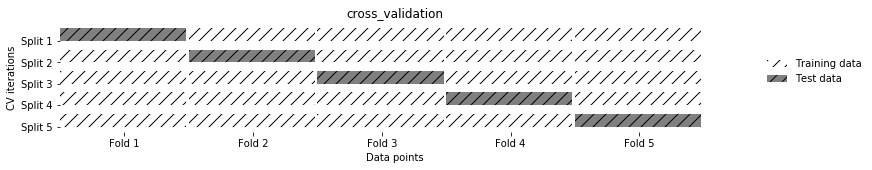

In [12]:
mglearn.plots.plot_cross_validation()

### Cross-validation in scikit-learn

* `cross_val_score` function with learner, training data, labels
* Returns list of all scores
    * Does 3-fold CV by default, can be changed via `cv` hyperparameter
    * Default scoring measures are accuracy (classification) or $R^2$ (regression)
* Even though models are built internally, they are not returned

``` python
knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(knn, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))
print("Variance in cross-validation score: {:.4f}".format(np.var(scores)))
```

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

iris = load_iris()
knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))
print("Variance in cross-validation score: {:.4f}".format(np.var(scores)))

Cross-validation scores: [0.98  0.922 1.   ]
Average cross-validation score: 0.97
Variance in cross-validation score: 0.0011


### More variants
* Stratified cross-validation: for inbalanced datasets
* Leave-one-out cross-validation: for very small datasets
* Shuffle-Split cross-validation: whenever you need to shuffle the data first
* Repeated cross-validation: more trustworthy, but more expensive
* Cross-validation with groups: Whenever your data contains non-independent datapoints, e.g. data points from the same patient
* Bootstrapping: sampling with replacement, for extracting statistical properties

### Avoid data leakage
- Simply taking the best performing model based on cross-validation performance yields optimistic results
- We've already used the test data to evaluate each model!
- Hence, we don't have an independent test set to evaluate these hyperparameter settings
    - Information 'leaks' from test set into the final model
- Solution: Set aside part of the training data to evaluate the hyperparameter settings
    - Select best model on validation set
    - Rebuild the model on the training+validation set
    - Evaluate optimal model on the test set

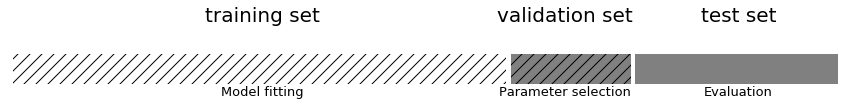

In [13]:
mglearn.plots.plot_threefold_split()

## Pipelines
* Many learning algorithms are greatly affected by _how_ you represent the training data
* Examples: Scaling, numeric/categorical values, missing values, feature selection/construction
* We typically need chain together different algorithms
    - Many _preprocessing_ steps
    - Possibly many models
* This is called a _pipeline_ (or _workflow_)
* The best way to represent data depends not only on the semantics of the data, but also on the kind of model you are using.

### Example: Speed dating data
* Data collected from speed dating events
* See https://www.openml.org/d/40536
* Could also be collected from dating website or app
* Real-world data:
    - Different numeric scales
    - Missing values
    - Likely irrelevant features
    - Different types: Numeric, categorical,...
    - Input errors (e.g. 'lawyer' vs 'Lawyer')
    
```
dating_data = fetch_openml("SpeedDating")
```

In [48]:
dating_data = fetch_openml("SpeedDating")

### Scaling

When the features have different scales (their values range between very different minimum and maximum values), one feature will overpower the others. Several scaling techniques are available to solve this:  
- `StandardScaler` rescales all features to mean=0 and variance=1
    - Does not ensure and min/max value
- `RobustScaler` uses the median and quartiles
    - Median m: half of the values < m, half > m
    - Lower Quartile lq: 1/4 of values < lq
    - Upper Quartile uq: 1/4 of values > uq
    - Ignores _outliers_, brings all features to same scale
- `MinMaxScaler` brings all feature values between 0 and 1
- `Normalizer` scales data such that the feature vector has Euclidean length 1
    - Projects data to the unit circle
    - Used when only the direction/angle of the data matters

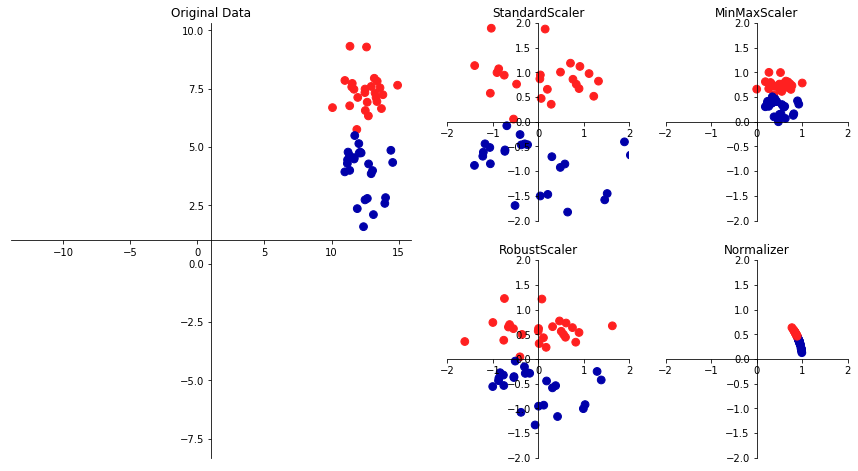

In [27]:
mglearn.plots.plot_scaling()

#### Applying scaling transformations
- Lets apply a scaling transformation _manually_, then use it to train a learning algorithm
- First, split the data in training and test set
- Next, we `fit` the preprocessor on the __training data__
    - This computes the necessary transformation parameters
    - For `MinMaxScaler`, these are the min/max values for every feature
- After fitting, we can `transform` the training and test data 

```python
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

### Feature Selection

It can be a good idea to reduce the number of features to only the most useful ones:
- Simpler models that generalize better
- Help algorithms that are sensitive to the number of features (e.g. kNN).

Use it when:

- You expect some inputs to be uninformative, and your model does not select features internally (as tree-based models do)
- You need to speed up prediction without loosing much accuracy
- You want a more interpretable model (with fewer variables)

#### Univariate feature selection

We want to keep the features for which there is statistically significant relationship between it and the target.
These test consider each feature individually (they are univariate), and are completely independent of the model that you might want to apply afterwards.

In scikit-learn we have two options:
- `SelectKBest` will only keep the $k$ features with the lowest p values. 
- `SelectPercentile` selects a fixed percentage of features. 

Retrieve the selected features with `get_support()`

We can use different tests to measure how informative a feature is: 

`f_regression`: For numeric targets. Measures the performance of a linear regression model trained on only one feature.

`f_classif`: For categorical targets. Measures the _F-statistic_ from one-way Analysis of Variance (ANOVA), or the proportion of total variance explained by one feature.

`chi2`: For categorical features and targets. Performs the chi-square statistic. Similar results as F-statistic, but less sensitive to nonlinear relationships.

For both the F-statistic and $\chi^2$, we actually obtain the p-value under the F- and $\chi^2$ distribution, respectively.

F-statistic = variation between sample means / mean variation within the samples (higher is better)  
$X_i$: all samples with class i.  
Better is samples means are far apart and variation within samples is small.

<img src="../images/03_fstatistic.png" alt="ml" style="width: 500px;"/>

Chi-squared for a feature with $c$ categories and $k$ classes:

$$\chi^2 = \sum_{i=0}^{c} \sum_{j=0}^{k} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

where $O_{ij}$ is the number of observations of feature category $i$ and class $j$, and $E_{ij}$ is the expected number of observations of category $i$ and class $j$ if there was no relationship between the feature and the target (number of samples of category $i$ * ratio of class $j$).


#### Model-based Feature Selection
Model-based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. They consider all features together, and are thus able to capture interactions: a feature may be more (or less) informative in combination with others.

The supervised model that is used for feature selection doesn’t need to be the same model that is used for the final supervised modeling, it only needs to be able to measure the (perceived) importance for each feature:

- Decision tree–based models return a `feature_importances_` attribute
- Linear models return coefficients, whose absolute values also reflect feature importance 

In scikit-learn, we can do this using `SelectFromModel`. It requires a model and a threshold. Threshold='median' means that the median observed feature importance will be the threshold, which will remove 50% of the features.
```
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")
```

### Iterative feature selection

Instead of building a model to remove many features at once, we can also just ask it to remove the worst feature, then retrain, remove another feature, etc. This is known as _recursive feature elimination_ (RFE).
```
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)
```

Vice versa, we could also ask it to iteratively add one feature at a time. This is called _forward selection_.

In both cases, we need to define beforehand how many features to select. When this is unknown, one often considers this as an additional hyperparameter of the whole process (pipeline) that needs to be optimized.

### Missing value imputation
* Many sci-kit learn algorithms cannot handle missing value
* `Imputer` replaces specific values
    * `missing_values` (default 'NaN') placeholder for the missing value
    * `strategy`:
        - `mean`, replace using the mean along the axis
        - `median`, replace using the median along the axis
        - `most_frequent`, replace using the most frequent value
* Many more advanced techniques exist, but not yet in scikit-learn
    * e.g. low rank approximations (uses matrix factorization)

``` python
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit_transform(X1_train)
```

### Feature encoding
* scikit-learn classifiers only handle numeric data. If your features are categorical, you need to encode them first
* `LabelEncoder` simply replaces each value with an integer value
* `OneHotEncoder` converts a feature of $n$ values to $n$ binary features
    * Provide `categories` as array or set to 'auto'
    
```python
X_enc = OneHotEncoder(categories='auto').fit_transform(X)

```

* `ColumnTransformer` can apply different transformers to different features
* Transformers can be pipelines doing multiple things

```python
numeric_features = ['age', 'pref_o_attractive']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['gender', 'd_d_age', 'field']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
```

## Building Pipelines
* In scikit-learn, a `pipeline` combines multiple processing _steps_ in a single estimator
* All but the last step should be transformer (have a `transform` method)
    * The last step can be a transformer too (e.g. Scaler+PCA)
* It has a `fit`, `predict`, and `score` method, just like any other learning algorithm
* Pipelines are built as a list of steps, which are (name, algorithm) tuples
    * The name can be anything you want, but can't contain `'__'`
    * We use `'__'` to refer to the hyperparameters, e.g. `svm__C`
* Let's build, train, and score a `MinMaxScaler` + `LinearSVC` pipeline:

``` python
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])
pipe.fit(X_train, y_train).score(X_test, y_test)
```

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=1)
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


* Now with cross-validation:
``` python
scores = cross_val_score(pipe, cancer.data, cancer.target)
```

In [38]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, cancer.data, cancer.target)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.984 0.953 0.979]
Average cross-validation score: 0.97


* We can retrieve the trained SVM by querying the right step indices
``` python
pipe.steps[1][1]
```

In [39]:
pipe.fit(X_train, y_train)
print("SVM component: {}".format(pipe.steps[1][1]))

SVM component: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


* Or we can use the `named_steps` dictionary
``` python
pipe.named_steps['svm']
```

In [40]:
print("SVM component: {}".format(pipe.named_steps['svm']))

SVM component: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


* When you don't need specific names for specific steps, you can use `make_pipeline`
    * Assigns names to steps automatically
``` python
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))
```

In [42]:
from sklearn.pipeline import make_pipeline
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), LinearSVC(C=100))
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('linearsvc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]


## Model selection and Hyperparameter tuning
* There are many algorithms to choose from
* Most algorithms have parameters (hyperparameters) that control model complexity
* Now that we know how to evaluate models, we can improve them selecting by `tuning` algorithms for your data

We can basically use any optimization technique to optimize hyperparameters:
 
- __Grid search__
- __Random search__

More advanced techniques:

- Local search
- Racing algorithms
- Bayesian optimization
- Multi-armed bandits
- Genetic algorithms

Grid vs Random Search
<img src="../images/eval_gridrandom.png" alt="ml" style="width: 800px;"/>

### Grid Search

- For each hyperparameter, create a list of interesting/possible values
    - E.g. For kNN: k in [1,3,5,7,9,11,33,55,77,99]
    - E.g. For SVM: C and gamma in [$10^{-10}$..$10^{10}$]
- Evaluate all possible combinations of hyperparameter values
    - E.g. using cross-validation
- Split the training data into a training and validation set
- Select the hyperparameter values yielding the best results on the validation set

#### Grid search in scikit-learn
- Create a parameter grid as a dictionary
    - Keys are parameter names
    - Values are lists of hyperparameter values
    
``` python
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))
```

In [14]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


- `GridSearchCV`: like a classifier that uses CV to automatically optimize its hyperparameters internally
    - Input: (untrained) model, parameter grid, CV procedure
    - Output: optimized model on given training data
    - Should only have access to training data
    
``` python
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
```

In [15]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The optimized test score and hyperparameters can easily be retrieved:

``` python
grid_search.score(X_test, y_test)
grid_search.best_params_
grid_search.best_score_
grid_search.best_estimator_
```

In [16]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.97
Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97
Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### Nested cross-validation

- Note that we are still using a single split to create the outer test set
- We can also use cross-validation here
- Nested cross-validation:
    - Outer loop: split data in training and test sets
    - Inner loop: run grid search, splitting the training data into train and validation sets
- Result is a just a list of scores
    - There will be multiple optimized models and hyperparameter settings (not returned)
- To apply on future data, we need to train `GridSearchCV` on all data again

``` python
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
```

In [17]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.967 1.    0.967 0.967 1.   ]
Mean cross-validation score:  0.9800000000000001


### Random Search

- Grid Search has a few downsides:
    - Optimizing many hyperparameters creates a combinatorial explosion
    - You have to predefine a grid, hence you may jump over optimal values
- Random Search:
    - Picks `n_iter` random parameter values
    - Scales better, you control the number of iterations
    - Often works better in practice, too
        - not all hyperparameters interact strongly
        - you don't need to explore all combinations

- Executing random search in scikit-learn:
    - `RandomizedSearchCV` works like `GridSearchCV`
    - Has `n_iter` parameter for the number of iterations
    - Search grid can use distributions instead of fixed lists
    
``` python
param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,
                                   n_iter=20)
random_search.fit(X_train, y_train)
random_search.best_estimator_
```

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,
                                   n_iter=20)
X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, random_state=0)
random_search.fit(X_train, y_train)
random_search.best_estimator_

SVC(C=6.109237791897481, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.04723626633903414,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Bayesian optimization

- The incremental updates you can do with Bayesian models allow a more effective way to optimize functions
    - E.g. to optimize the hyperparameter settings of a machine learning algorithm/pipeline
- After a number of random search iterations we know more about the performance of hyperparameter settings on the given dataset
- We can use this data to train a model, and predict which other hyperparameter values might be useful
    - More generally, this is called model-based optimization
    - This model is called a _surrogate model_
- This is often a probabilistic (e.g. Bayesian) model that predicts confidence intervals for all hyperparameter settings
- We use the predictions of this model to choose the next point to evaluate
- With every new evaluation, we update the surrogate model and repeat

#### Example (see figure): 

- Consider only 1 continuous hyperparameter (X-axis)
    - You can also do this for many more hyperparameters 
- Y-axis shows cross-validation performance
- Evaluate a number of random hyperparameter settings (black dots)
    - Sometimes an initialization design is used
- Train a model, and predict the expected performance of other (unseen) hyperparameter values
    - Mean value (black line) and distribution (blue band)
- An _acquisition function_ (green line) trades off maximal expected performace and maximal uncertainty
    - Exploitation vs exploration
- Optimal value of the asquisition function is the next hyperparameter setting to be evaluated
- Repeat a fixed number of times, or until time budget runs out

<img src="../images/03_Bayesian_optimization.png" alt="ml" style="width: 800px;"/>

<img src="../images/05_2dbo.png" alt="ml" style="width: 800px;"/>

#### Auto-sklearn
* Different libraries exist for Bayesian optimization
* E.g. auto-sklearn
    - Drop-in sklearn classifier
    - Also optimizes pipelines (e.g. feature selection)
    - Uses OpenML to find good models on similar datasets
    - Lacks Windows support
    
```python
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60, # sec., for entire process
    per_run_time_limit=15, # sec., for each model
    ml_memory_limit=1024, # MB, memory limit
)
automl.fit(X_train, y_train)
```

### Bandit-based techniques
- Multi-arm bandits: Find best of $n$ choices ('arms'), each try ('pull') gives only partial information
- Successive halving for model selection:
    - Test every model initially on small part of the data
    - Train 50% best models (green) on twice the amount of data, repeat
- Avoid premature removal by restarting a random subset on a larger initial training set

<img src="../images/eval_hyperband.png" alt="ml" style="width: 800px;"/>

#### Hyperband
* Hyperparameter tuning with bandits (Hyperband)
* Different implementations exist, [including scikit-learn drop-ins](https://github.com/thuijskens/scikit-hyperband)
* At the moment still experimental (e.g. no preprocessing support)

### Using Pipelines in Grid-searches
* We can use the pipeline as a single estimator in `cross_val_score` or `GridSearchCV`
* To define a grid, refer to the hyperparameters of the steps
    * Step `svm`, parameter `C` becomes `svm__C`
    
```python
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
```

In [43]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [46]:
from sklearn import pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


pipe = pipeline.Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.97
Test set score: 0.97
Best parameters: {'svm__C': 10, 'svm__gamma': 1}
